IMPORT Library

In [39]:
import pandas as pd
import numpy as np
import nltk
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

import os
nltk.data.path.append(os.path.expanduser('~/nltk_data'))

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


READING

In [5]:
# Path ke file yang sesuai
file_path = '/home/user/Python/book/DL_proyek/env_nlp/Data_Berita.xlsx'
df = pd.read_excel(file_path)

# Tampilkan beberapa baris
df[['Date', 'Headline','Content', 'Label']].head()

,Date,Headline,Content,Label
0,2024-10-31 23:30:00,3 Cara Cek Penerima PIP Kemdikbud Online dan O...,Status penerima Program Indonesia Pintar (PIP)...,1
1,2024-10-31 23:23:00,Daftar Harga BBM Pertamina yang Naik Mulai 1 N...,Harga bahan bakar minyak (BBM) nonsubsidi kelu...,1
2,2024-10-31 23:00:00,50+ Soal Manajerial PPPK 2024 Lengkap Kunci Ja...,detikers sedang mencari referensi contoh soal ...,1
3,2024-10-31 12:54:00,Video: Rano Janji Perhatikan Nasib Relawan Kes...,"Cawagub Jakarta nomor urut 3, Rano Karno, mend...",1
4,2024-10-31 22:40:00,Tokopedia Beberkan Penyebab iPhone 16 Lenyap d...,Tokopedia akhirnya membeberkan alasan kenapa i...,1


PREPROCESSING

In [10]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import re

# Tokenizer hanya untuk kata (hapus tanda baca)
tokenizer_nltk = RegexpTokenizer(r'\w+')
indo_stopwords = set(stopwords.words('indonesian'))

# Fungsi bersihkan teks
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # hapus angka
    tokens = tokenizer_nltk.tokenize(text)
    tokens = [word for word in tokens if word not in indo_stopwords and len(word) > 2]
    return tokens

# Terapkan ke dataframe
df['tokens'] = df['Content'].astype(str).apply(clean_text)
df['text'] = df['tokens'].apply(lambda x: ' '.join(x))

texts = df['text'].values
labels = df['Label'].values

# Tokenizer dari Keras untuk word_index
keras_tokenizer = Tokenizer()
keras_tokenizer.fit_on_texts(texts)
word_index = keras_tokenizer.word_index

LATIH MODEL WORD2VEC

In [41]:
# Latih model Word2Vec
model_w2v = Word2Vec(sentences=df['tokens'], vector_size=50, window=5, min_count=1, workers=4, epochs=20)

# Simpan model jika diperlukan
model_w2v.save("word2vec_berita.model")

TOKENASI dan PADDING

In [17]:
# 1. Tokenisasi
keras_tokenizer = Tokenizer()
keras_tokenizer.fit_on_texts(df['text'].values)
sequences = keras_tokenizer.texts_to_sequences(df['text'].values)
word_index = keras_tokenizer.word_index
print(f"Jumlah kata unik: {len(word_index)}")

# 2. Padding
max_length = 200
X = pad_sequences(sequences, maxlen=max_length)
y = df['Label'].values

Jumlah kata unik: 78747


BUAT EMBEDDING MATRIX dari WORD2VEC 50 Dimension

In [18]:
embedding_dim = 50
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in model_w2v.wv:
        embedding_matrix[i] = model_w2v.wv[word]

SPLIT DATA TRAIN, VALID & TEST

In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(padded, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

BUILD MODEL Bidirectional LSTM

In [23]:
model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=embedding_dim, input_shape=(max_length,)),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 200, 50)        │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        58,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,201 (2.16 MB)

 Trainable params: 567,201 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

TRAIN MODEL & Simpan Evaluasi Model

In [25]:
# Model compile
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Model fit
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Evaluasi model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# Tampilkan jumlah kata unik
print(f"Jumlah kata unik dalam word_index: {len(word_index)}")

Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9052 - loss: 0.3061 - val_accuracy: 0.9971 - val_loss: 0.0232
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9989 - loss: 0.0088 - val_accuracy: 0.9943 - val_loss: 0.0103
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9997 - loss: 0.0033 - val_accuracy: 0.9971 - val_loss: 0.0077
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9989 - loss: 0.0034 - val_accuracy: 0.9943 - val_loss: 0.0151
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9992 - loss: 0.0053 - val_accuracy: 0.9971 - val_loss: 0.0082
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9991 - loss: 0.0047 - val_accuracy: 0.9957 - val_loss: 0.0138
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9957 - val_loss: 0.0150
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9994 - loss: 0.0027 - val_acc

In [30]:
# Simpan model ke file .h5
model.save('model_berita_bilstm.h5')
print("Model berhasil disimpan ke model_berita_bilstm.h5")

# Load model dari file .h5
model = load_model('model_berita_bilstm.h5')

# Gunakan model untuk evaluasi
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi model yang dimuat ulang: {accuracy * 100:.2f}%")

Model berhasil disimpan ke model_berita_bilstm.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9861 - loss: 0.0502
Akurasi model yang dimuat ulang: 99.00%


Evaluasi Model dan Prediksi

In [37]:
# Simpan indeks setelah split
indices = df.index.values
# 1. PREDIKSI
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# 2. EVALUASI METRIK
print("=== Evaluasi Model Bidirectional LSTM ===")
print(f"Akurasi       : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision     : {precision_score(y_test, y_pred):.4f}")
print(f"Recall        : {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score      : {f1_score(y_test, y_pred):.4f}")
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=['Hoax', 'Real']))

# 3. SIMPAN PREDIKSI KE DATAFRAME
df_test = df.loc[idx_test].copy()
df_test['Predicted_Label'] = y_pred
df_test['Prediction_Prob'] = y_pred_prob.flatten()
df_test['Hasil_Klasifikasi'] = df_test['Predicted_Label'].apply(lambda x: 'Real' if x == 1 else 'Hoax')

# 4. SIMPAN KE EXCEL
excel_filename = "hasil_prediksi_hoax.xlsx"
df_test.to_excel(excel_filename, index=False)
print(f"\nHasil prediksi disimpan ke file: {excel_filename}")

# 5. BACA ULANG HASIL (opsional)
df_hasil = pd.read_excel(excel_filename)
print("\n=== 5 Data Teratas dari Hasil Prediksi ===")
print(df_hasil.head())

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
=== Evaluasi Model Bidirectional LSTM ===
Akurasi       : 0.9900
Precision     : 0.9812
Recall        : 1.0000
F1 Score      : 0.9905

=== Classification Report ===
              precision    recall  f1-score   support

        Hoax       1.00      0.98      0.99       331
        Real       0.98      1.00      0.99       366

    accuracy                           0.99       697
   macro avg       0.99      0.99      0.99       697
weighted avg       0.99      0.99      0.99       697


Hasil prediksi disimpan ke file: hasil_prediksi_hoax.xlsx

=== 5 Data Teratas dari Hasil Prediksi ===
                 Date                                           Headline  \
0 2024-06-30 00:00:00  [SALAH]: Pengibaran bendera GAM usai MK menang...   
1 2024-07-20 23:15:00  Indra Sjafri Apresiasi Perjuangan Keras Timnas...   
2 2024-05-13 00:00:00  [SALAH] Timnas New Guinea Didiskualifikasi Dar...   
3 2024-03-26 21:16:00         Mantap! Timnas Indonesia Hajar 

Plot VISUALISASI Metrik & Akurasi

============= Grafik Batang: Distribusi Hasil Prediksi Real vs Hoax =================


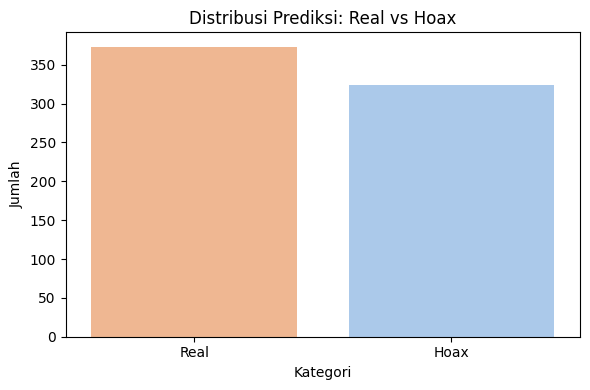

============= Grafik Line: Akurasi & Loss per Epoch dari history model =================


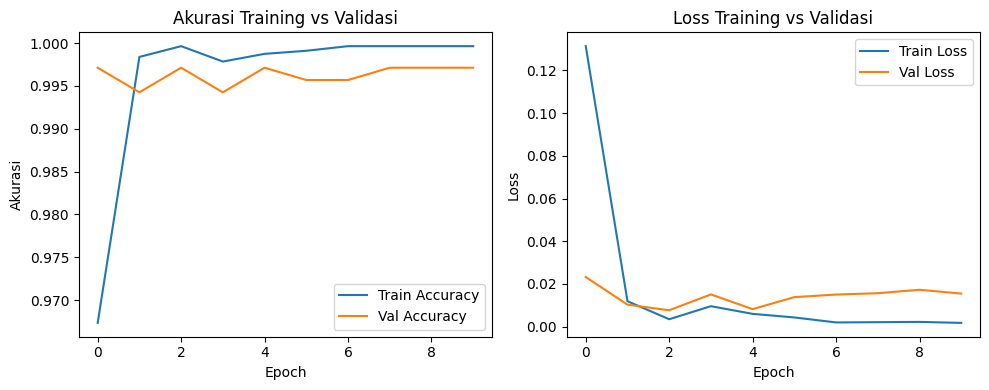

============= Confusion Matrix: Visualisasi Hasil Klasifikasi =================


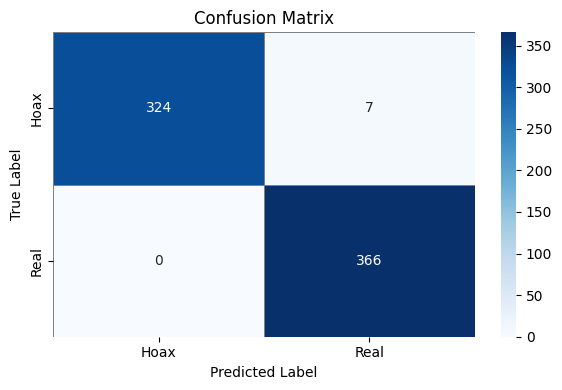

============= Grafik Heatmap =================


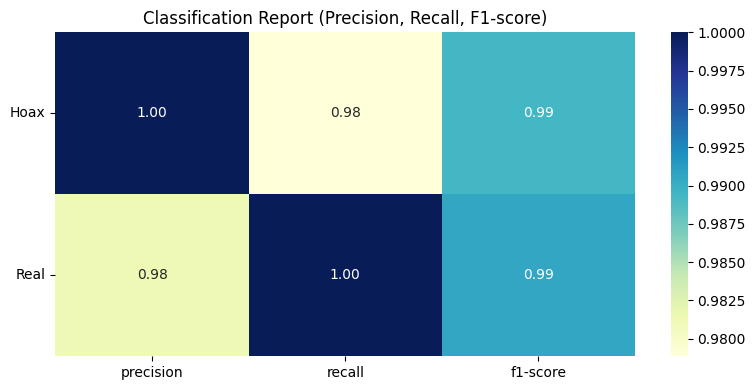

============= Klasifikasi jumlah data =================
Jumlah total data: 6965
Train: 5572
Validation: 696
Test: 697


In [47]:
# Pastikan df_test sudah ada dari proses prediksi & evaluasi sebelumnya

# 1. Grafik Batang: Distribusi Hasil Prediksi Real vs Hoax
print("============= Grafik Batang: Distribusi Hasil Prediksi Real vs Hoax =================")
plt.figure(figsize=(6, 4))
order = ['Real', 'Hoax'] if 'Real' in df_test['Hasil_Klasifikasi'].values else df_test['Hasil_Klasifikasi'].unique()
sns.countplot(data=df_test, x='Hasil_Klasifikasi', hue='Hasil_Klasifikasi',
              palette='pastel', order=order, legend=False)
plt.title('Distribusi Prediksi: Real vs Hoax')
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()


# 2. Grafik Line: Akurasi & Loss per Epoch dari history model
print("============= Grafik Line: Akurasi & Loss per Epoch dari history model =================")
if 'history' in globals():
    plt.figure(figsize=(10, 4))

    # Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Akurasi Training vs Validasi')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Training vs Validasi')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("History model tidak ditemukan. Pastikan Anda sudah menjalankan proses training dan memiliki variabel 'history'.")

# 3. Confusion Matrix: Visualisasi Hasil Klasifikasi
print("============= Confusion Matrix: Visualisasi Hasil Klasifikasi =================")
cm = confusion_matrix(y_test, y_pred)
labels = ['Hoax', 'Real']
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor='gray')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 4. Buat classification report
report = classification_report(y_test, y_pred, target_names=['Hoax', 'Real'], output_dict=True)
df_report = pd.DataFrame(report).transpose()

# 5. Plot heatmap
print("============= Grafik Heatmap =================")
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:2, :-1], annot=True, cmap='YlGnBu', fmt=".2f")  # Hanya Hoax & Real
plt.title('Classification Report (Precision, Recall, F1-score)')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 6. Klasifikasi jumlah data
print("============= Klasifikasi jumlah data =================")
print("Jumlah total data:", len(df))
print("Train:", len(X_train))
print("Validation:", len(X_val))
print("Test:", len(X_test))